In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import shutil
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(1337)

In [2]:
import h5py

train_file = 'MA0035_4_m0_train.h5'
test_file = 'MA0035_4_m0_test.h5'

h5_train = h5py.File(train_file, 'r')
h5_test = h5py.File(test_file, 'r')

train_data = h5_train['data'][:90000]
train_binlabels = h5_train['binlabels'][:90000]

val_data = h5_train['data'][-10000:]
val_binlabels = h5_train['binlabels'][-10000:]

test_data = h5_test['data'][:]
test_binlabels = h5_test['binlabels'][:]

train_data = tf.cast(train_data, dtype=tf.float32)
train_labels = tf.cast(train_binlabels, dtype=tf.float32)

In [3]:
print(train_data.shape)
train_data_T = np.transpose(train_data, axes=(0, 2, 1))
print(train_data_T.shape)

(90000, 4, 1000)
(90000, 1000, 4)


In [4]:
print(test_data.shape)
test_data_T = np.transpose(test_data, axes=(0, 2, 1))
print(test_data_T.shape)

(10000, 4, 1000)
(10000, 1000, 4)


In [5]:
print(val_data.shape)
val_data_T = np.transpose(val_data, axes=(0, 2, 1))
print(val_data_T.shape)

(10000, 4, 1000)
(10000, 1000, 4)


In [6]:
def train_model(hyperparameters, log_dir):
    board_log = log_dir + '/board'
    hparams_log = log_dir + '/hparams.json'

    my_callbacks = [
        TensorBoard(log_dir=board_log),
        EarlyStopping('val_loss', patience=100)
    ]

    with open(hparams_log, 'w') as hparam_file:
        json.dump(hyperparameters, hparam_file)

    model = tf.keras.models.Sequential(
        [
            Flatten(input_shape=(1000, 4)),
            Dropout(hyperparameters['l0_dropout_rate']),
            Dense(100, activation='relu', kernel_regularizer='l2', bias_regularizer='l2'),
            Dropout(0.5),
            Dense(30, activation='relu'),
            Dropout(0.6),
            Dense(30, activation='relu', kernel_regularizer='l2', bias_regularizer='l2'),
            Dense(5, activation='relu'),
            Dense(1, activation=tf.keras.activations.sigmoid)
        ]
    )

    with tf.device('/GPU:0'):
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparameters['learning_rate']),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.AUC(name='auc')],
        )

        history = model.fit(train_data_T, train_binlabels,
                epochs=hyperparameters['epochs'], 
                validation_data=(val_data_T, val_binlabels),
                batch_size=hyperparameters['batch_size'],
                callbacks=my_callbacks,
                shuffle=True)

    return model, history

In [7]:
def plot_and_save_roc(false_positive_rate, true_positive_rate, log_dir):
    roc = plt.figure(0)

    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    plt.savefig(log_dir + '/roc.pdf')
    pickle.dump(roc, open((log_dir + '/pickle/roc.fig.pickle'), 'wb'))

In [8]:
def plot_and_save_loss(history, log_dir):
    loss = plt.figure(1)
    history_loss = history.history['loss']
    history_val_loss = history.history['val_loss']
    epochs = range(len(history_loss))

    plt.plot(epochs, history_loss, 'ko', label='Training loss')
    plt.plot(epochs, history_val_loss, 'b', label='Validation loss')
    plt.ylim([0.0, 1.5])
    plt.title('Training and validation loss')
    plt.legend()

    plt.savefig(log_dir + '/loss.pdf')
    pickle.dump(loss, open((log_dir + '/pickle/loss.fig.pickle'), 'wb'))

In [9]:
def plot_and_save_auc(history, log_dir):
    auc = plt.figure(2)

    history_auc = history.history['auc']
    history_val_auc = history.history['val_auc']
    epochs = range(len(history_auc))

    plt.plot(epochs, history_auc, 'ko', label='Training auc')
    plt.plot(epochs, history_val_auc, 'b', label='Validation auc')
    plt.title('Training and validation auc')
    plt.ylim(0.46, 1.0)
    plt.legend()

    plt.savefig(log_dir + '/auc.pdf')
    pickle.dump(auc, open((log_dir + '/pickle/auc.fig.pickle'), 'wb'))

In [10]:
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

[Errno 2] No such file or directory: './logs/4_h_layer_test/:0.0|hu100l2|dr0.5|hu30|dr0.6|hu30l2|hu5lr2.3e-06'
Epoch 1/300
704/704 [==============================] - 3s 4ms/step - loss: 2.7667 - auc: 0.5018 - val_loss: 2.5539 - val_auc: 0.4989
Epoch 2/300
704/704 [==============================] - 2s 3ms/step - loss: 2.5953 - auc: 0.4963 - val_loss: 2.4735 - val_auc: 0.4990
Epoch 3/300
704/704 [==============================] - 2s 3ms/step - loss: 2.5168 - auc: 0.4941 - val_loss: 2.4047 - val_auc: 0.4987
Epoch 4/300
704/704 [==============================] - 2s 3ms/step - loss: 2.4374 - auc: 0.4954 - val_loss: 2.3357 - val_auc: 0.5007
Epoch 5/300
704/704 [==============================] - 2s 3ms/step - loss: 2.3608 - auc: 0.4931 - val_loss: 2.2680 - val_auc: 0.5016
Epoch 6/300
704/704 [==============================] - 2s 3ms/step - loss: 2.2784 - auc: 0.5043 - val_loss: 2.1984 - val_auc: 0.5027
Epoch 7/300
704/704 [==============================] - 2s 3ms/step - loss: 2.2047 - auc: 0.

704/704 [==============================] - 2s 3ms/step - loss: 0.6256 - auc: 0.5166 - val_loss: 0.6464 - val_auc: 0.5047
Epoch 62/300
704/704 [==============================] - 2s 3ms/step - loss: 0.6188 - auc: 0.5203 - val_loss: 0.6401 - val_auc: 0.5025
Epoch 63/300
704/704 [==============================] - 2s 3ms/step - loss: 0.6113 - auc: 0.5156 - val_loss: 0.6333 - val_auc: 0.5036
Epoch 64/300
704/704 [==============================] - 2s 3ms/step - loss: 0.6045 - auc: 0.5214 - val_loss: 0.6289 - val_auc: 0.5037
Epoch 65/300
704/704 [==============================] - 2s 3ms/step - loss: 0.6014 - auc: 0.5211 - val_loss: 0.6228 - val_auc: 0.5033
Epoch 66/300
704/704 [==============================] - 2s 3ms/step - loss: 0.5953 - auc: 0.5174 - val_loss: 0.6172 - val_auc: 0.5021
Epoch 67/300
704/704 [==============================] - 2s 3ms/step - loss: 0.5896 - auc: 0.5193 - val_loss: 0.6106 - val_auc: 0.5043
Epoch 68/300
704/704 [==============================] - 3s 4ms/step - loss:

704/704 [==============================] - 2s 3ms/step - loss: 0.4273 - auc: 0.5488 - val_loss: 0.4423 - val_auc: 0.4977
Epoch 123/300
704/704 [==============================] - 2s 3ms/step - loss: 0.4308 - auc: 0.5441 - val_loss: 0.4430 - val_auc: 0.4985
Epoch 124/300
704/704 [==============================] - 2s 3ms/step - loss: 0.4270 - auc: 0.5469 - val_loss: 0.4417 - val_auc: 0.5005
Epoch 125/300
704/704 [==============================] - 2s 3ms/step - loss: 0.4266 - auc: 0.5407 - val_loss: 0.4415 - val_auc: 0.4983
Epoch 126/300
704/704 [==============================] - 2s 3ms/step - loss: 0.4287 - auc: 0.5417 - val_loss: 0.4381 - val_auc: 0.4997
Epoch 127/300
704/704 [==============================] - 2s 3ms/step - loss: 0.4232 - auc: 0.5529 - val_loss: 0.4361 - val_auc: 0.4996
Epoch 128/300
704/704 [==============================] - 2s 3ms/step - loss: 0.4250 - auc: 0.5449 - val_loss: 0.4352 - val_auc: 0.4989
Epoch 129/300
704/704 [==============================] - 2s 3ms/step 

Epoch 183/300
704/704 [==============================] - 2s 3ms/step - loss: 0.3786 - auc: 0.5868 - val_loss: 0.3886 - val_auc: 0.4972
Epoch 184/300
704/704 [==============================] - 3s 4ms/step - loss: 0.3816 - auc: 0.5888 - val_loss: 0.3875 - val_auc: 0.4987
Epoch 185/300
704/704 [==============================] - 2s 3ms/step - loss: 0.3860 - auc: 0.5842 - val_loss: 0.3875 - val_auc: 0.4986
Epoch 186/300
704/704 [==============================] - 2s 3ms/step - loss: 0.3816 - auc: 0.5785 - val_loss: 0.3874 - val_auc: 0.4981
Epoch 187/300
704/704 [==============================] - 2s 3ms/step - loss: 0.3785 - auc: 0.5908 - val_loss: 0.3862 - val_auc: 0.4972
Epoch 188/300
704/704 [==============================] - 2s 3ms/step - loss: 0.3797 - auc: 0.5873 - val_loss: 0.3868 - val_auc: 0.4990
Epoch 189/300
704/704 [==============================] - 2s 3ms/step - loss: 0.3787 - auc: 0.5929 - val_loss: 0.3859 - val_auc: 0.4974
Epoch 190/300
704/704 [==============================] 

704/704 [==============================] - 4s 5ms/step - loss: 0.3597 - auc: 0.6343 - val_loss: 0.3757 - val_auc: 0.4964
Epoch 244/300
704/704 [==============================] - 4s 5ms/step - loss: 0.3574 - auc: 0.6339 - val_loss: 0.3749 - val_auc: 0.4969
Epoch 245/300
704/704 [==============================] - 4s 5ms/step - loss: 0.3570 - auc: 0.6335 - val_loss: 0.3746 - val_auc: 0.4968
Epoch 246/300
704/704 [==============================] - 3s 5ms/step - loss: 0.3610 - auc: 0.6361 - val_loss: 0.3762 - val_auc: 0.4960
Epoch 247/300
704/704 [==============================] - 3s 5ms/step - loss: 0.3582 - auc: 0.6368 - val_loss: 0.3749 - val_auc: 0.4964
Epoch 248/300
704/704 [==============================] - 3s 5ms/step - loss: 0.3581 - auc: 0.6394 - val_loss: 0.3743 - val_auc: 0.4961
Epoch 249/300
704/704 [==============================] - 3s 5ms/step - loss: 0.3589 - auc: 0.6367 - val_loss: 0.3745 - val_auc: 0.4969
Epoch 250/300
704/704 [==============================] - 3s 5ms/step 

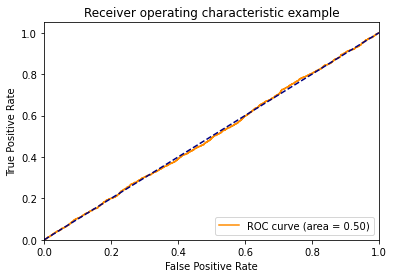

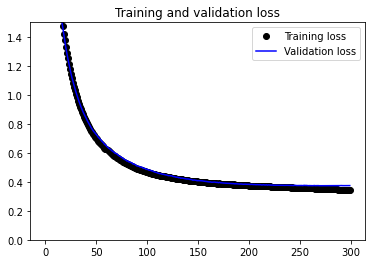

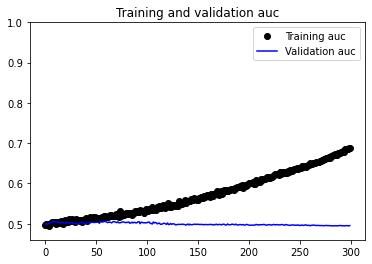

INFO:tensorflow:Assets written to: ./logs/4_h_layer_test/:0.0|hu100l2|dr0.5|hu30|dr0.6|hu30l2|hu5lr2.3e-06/model/assets


In [11]:
L0_DROPOUT_RATES = [0.0,]
BATCH_SIZE = [32, 64, 128, 254, 512]
LEARNING_RATE = [0.0000023]

for l0_dropout_rate in L0_DROPOUT_RATES:
    log_dir = './logs/4_h_layer_test/:' + str(l0_dropout_rate) + '|hu100l2|dr0.5|hu30|dr0.6|hu30l2|hu5lr' + str(LEARNING_RATE[0])

    try:
        shutil.rmtree(log_dir)
    except OSError as e:
        print(e)

    try:
        os.makedirs(log_dir)
        os.makedirs(log_dir + '/pickle')
    except OSError as e:
        print(e)

    hparams = {
        'l0_dropout_rate': l0_dropout_rate,
        'learning_rate': LEARNING_RATE[0],
        'batch_size': BATCH_SIZE[2],
        'epochs': 300,
    }

    model, history = train_model(hparams, log_dir)

    acc, auc = model.evaluate(test_data_T, test_binlabels)
    yhat = model.predict(test_data)
    fpr, tpr, _ = roc_curve(test_binlabels, yhat)
    roc_auc = roc_auc_score(test_binlabels, yhat)

    plot_and_save_roc(fpr, tpr, log_dir)
    plot_and_save_loss(history, log_dir)
    plot_and_save_auc(history, log_dir)

    plt.show()
    model.save(log_dir + '/model')